# SOM for SL PCA coefficients


- author : Sylvie Dagoret-Campagne
- affiliation  : IJCLab
- creation date : 2023/01/10
- last update : 2023-01-13

- Intuitive introduction to SOM in youtube : https://www.youtube.com/watch?v=lFbxTlD5R98


- https://github.com/JustGlowing/minisom
- https://github.com/JustGlowing/minisom/blob/master/examples/Clustering.ipynb
- https://github.com/sylvielsstfr/Photoz-tools/blob/sdc_2022/KSOM_lsst.ipynb
- https://github.com/JospehCeh/PhotoZ_PhD/tree/u/dagoret

https://heartbeat.comet.ml/introduction-to-self-organizing-maps-soms-98e88b568f5d

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#from sklearn_som.som import SOM
from minisom import MiniSom

In [3]:
%matplotlib inline
import os
import numpy as np
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import pandas as pd
import seaborn as sns 
import itertools
sns.set_style("white")
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
sns.set_palette(sns.color_palette(["#9b59b6", "#95a5a6", 
                                   "#e74c3c", "#3498db", 
                                   "#34495e", "#2ecc71"]))
import copy
from itertools import cycle

In [4]:
from astropy.io import fits

## Start

In [5]:
cwd=os.path.abspath("")
main_dir = cwd
print(f"notebook current executing path : {cwd}")

notebook current executing path : /Users/sylvie/MacOSX/GitHub/LSST/PhotoZ_PhD/SOM


## Config

### Check convergence

In [6]:
FLAG_CHECK_CONVERGENCE = True
FLAG_VIEW_CLUSTERING = True

## Read input file

In [7]:
all_filenames = ['datatools/pcamethod1_SL_eigenvectorandcoeff.fits']

# choose the SED
infile_idx=0
filename = all_filenames[infile_idx]
hdu = fits.open(filename)
hdu.info()

Filename: datatools/pcamethod1_SL_eigenvectorandcoeff.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      12   (6362, 553)   float64   
  1                1 ImageHDU         8   (10, 550)   float64   
  2                1 ImageHDU         8   (6361, 10)   float64   


### Read Spectra

In [8]:
data1=hdu[0].data
hdr1 = hdu[0].header
hdr1

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 6362                                                  
NAXIS2  =                  553                                                  
EXTEND  =                    T                                                  
DATAWLS = 'data[0,1:]'                                                          
DATALLAV= 'data[1,1:]'                                                          
DATALLST= 'data[2,1:]'                                                          
DATAFL  = 'data[3:,1:]'                                                         
DATANUM = 'data[3:,0]'                                                          
COMMENT Spectra of StarLight                                                    

### Read PCA coefficients

In [9]:
data2=hdu[1].data
hdr2 = hdu[1].header
hdr2

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   10                                                  
NAXIS2  =                  550                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
COMMENT PCA method 1 spectra coefficients                                       

### Read PCA eigenvectors

In [10]:
data3=hdu[2].data
hdr2 = hdu[2].header
hdr2

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 6361                                                  
NAXIS2  =                   10                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
COMMENT PCA method 1 Eigen Vectors                                              

## Decode data

### Decode spectra data

In [11]:
wavelengths = data1[0,1:] 
flambdas_average = data1[1,1:] 
flambdas_std = data1[2,1:] 
spec = data1[3:,1:] 
all_numbers = data1[3:,0] 


### Decode PCA data

In [12]:
X = copy.deepcopy(data2[:,:])

# Normalize the data

- I think one should not standardize PCA coefficients

In [13]:
#X = (spec - np.mean(spec, axis=0)) / np.std(spec, axis=0)

# SOM

- The best Intuitive introduction to SOM can be found in  youtube : https://www.youtube.com/watch?v=lFbxTlD5R98 in Kimia lab chain

### SOM principle and initialisation

Input: dataset, size and topology of the map

Output: the codebook for each output node

        Randomize the map’s nodes weight
        Select randomly one instance
        Find the closest node: best matching unit
        The codebook of this node is updated
        The codebooks of the adjacent nodes are also updated, by not to the same degree
        Reduce the intensity of the update progressively
        Repeat 1 to 6 for Tmax iterations

Weight update rule for a node
, knowing that

is the winning node:

: learning rate

: neighbourhood function
where

is the euclidian distance between node i and j on Kohonen (flat-2D ) map

and

    are hyperparameters



- https://github.com/sylvielsstfr/Photoz-tools/blob/sdc_2022/KSOM_lsst.ipynb

In [14]:
# Initialization and training

n_neurons = 70
m_neurons = 70

learning_rate_0=0.5
sigma_0 = 14
Niter = 500

#som = MiniSom(n_neurons, m_neurons, X.shape[1], sigma=1.5, learning_rate=.1, neighborhood_function='gaussian', random_seed=0)
#som = MiniSom(n_neurons, m_neurons, X.shape[1], sigma=7, learning_rate=.5, neighborhood_function='gaussian', random_seed=0)
som = MiniSom(n_neurons, m_neurons, X.shape[1], sigma=sigma_0, learning_rate=learning_rate_0, neighborhood_function='gaussian', random_seed=0)
              
    
som.pca_weights_init(X)
som.train(X, Niter, verbose=True)  # random training

 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 0.00045449663721006014


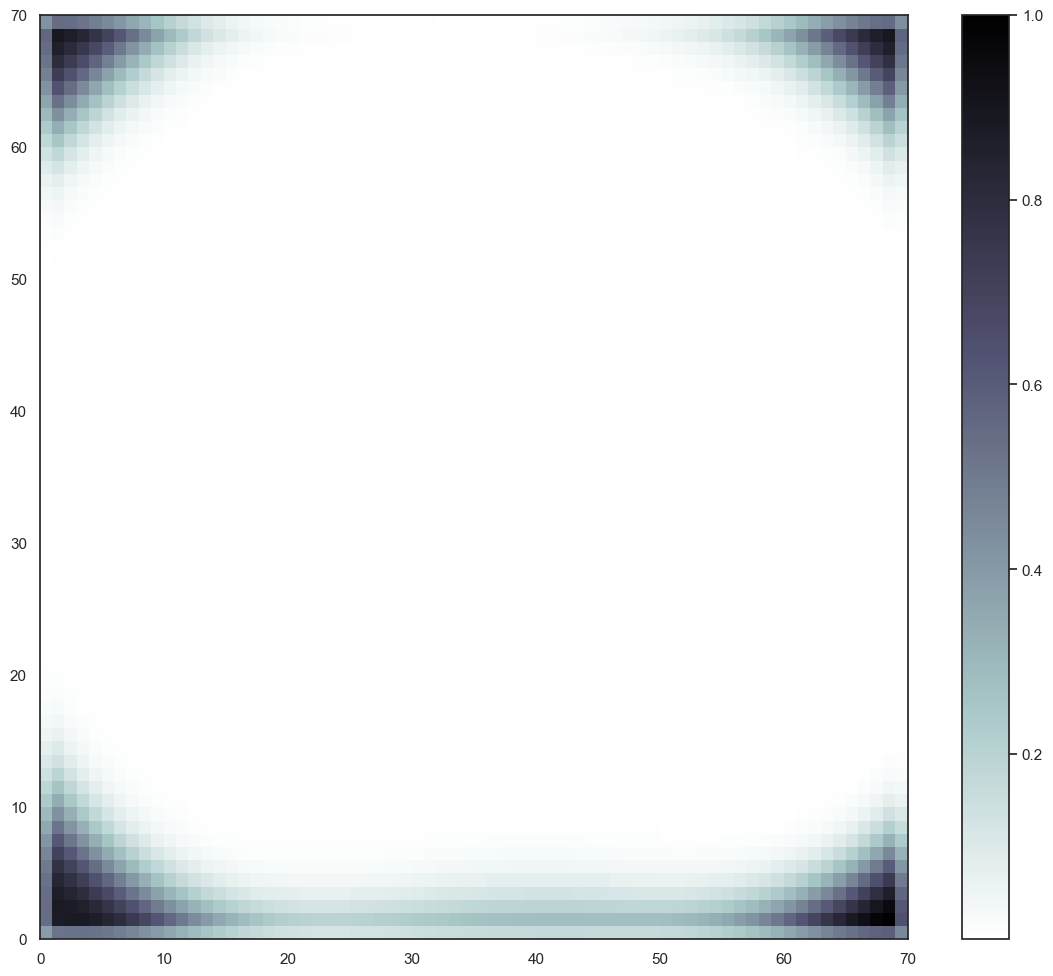

In [15]:
plt.figure(figsize=(14, 12))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

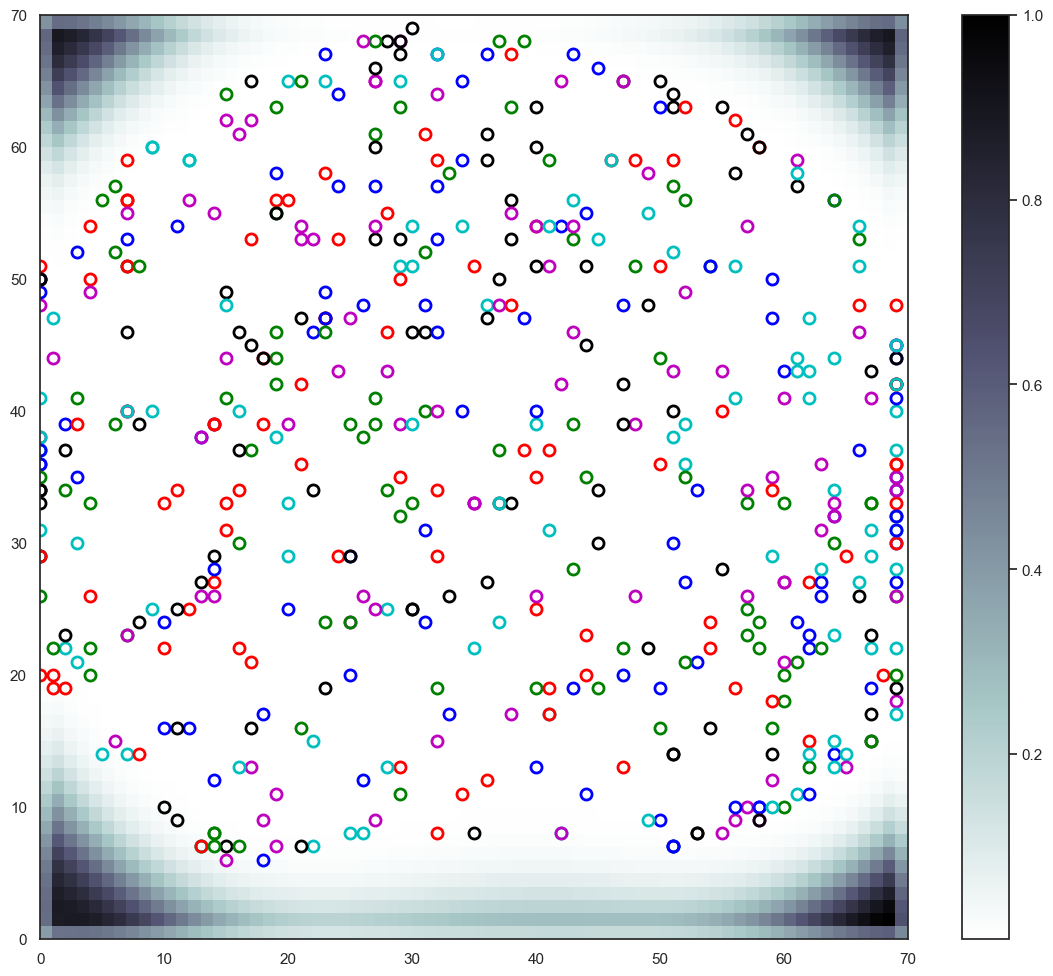

In [16]:
cycol = cycle('bgrcmk')

plt.figure(figsize=(14, 12))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the iris dataset
# different colors and markers for each label

for cnt, xx in enumerate(X):
    w = som.winner(xx)  # getting the winner
    # place a marker on the winning position for the sample xx
    plt.plot(w[0], w[1], 'o', markerfacecolor='None',markeredgecolor=next(cycol), markersize=8, markeredgewidth=2)

plt.show()


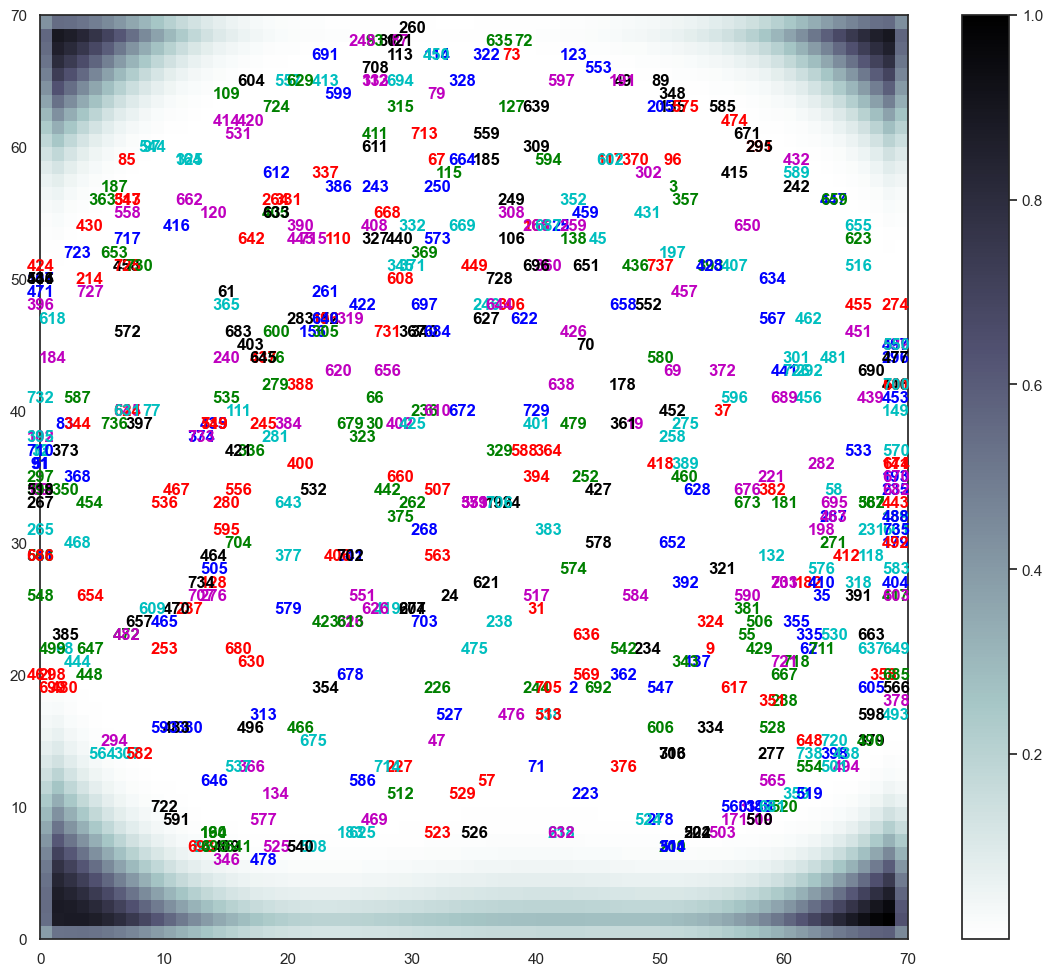

In [17]:
cycol = cycle('bgrcmk')

plt.figure(figsize=(14, 12))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the iris dataset
# different colors and markers for each label

for cnt, xx in enumerate(X):
    w = som.winner(xx)  # getting the winner
    # place a marker on the winning position for the sample xx
    #plt.plot(w[0], w[1], 'o', markerfacecolor='None',markeredgecolor='r', markersize=5, markeredgewidth=2)
    the_num=int(all_numbers[cnt])
    plt.text(w[0],w[1],the_num, color=next(cycol),ha="center", va="center",fontsize=12,fontweight='bold')

plt.show()


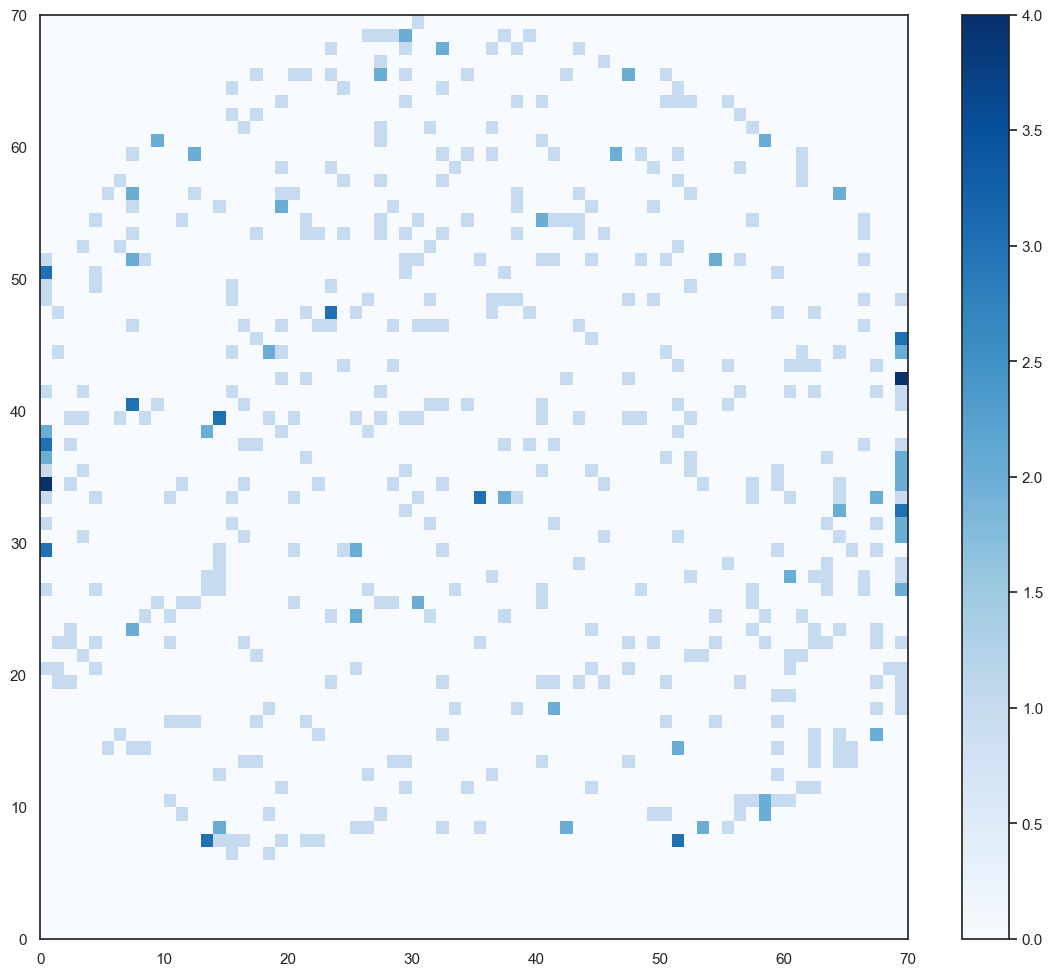

In [18]:
plt.figure(figsize=(14, 12))
frequencies = som.activation_response(X)
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.show()


## Clustering on SOM

In [19]:
from sklearn.cluster import KMeans

In [20]:
if not FLAG_VIEW_CLUSTERING:
    assert False

In [21]:
all_positions = []
for cnt, xx in enumerate(X):
    w = som.winner(xx)  # getting the winner
    all_positions.append(w)
all_positions=np.vstack(all_positions)

In [22]:
X1=all_positions

In [23]:
n_clu = 50
km = KMeans(n_clusters = n_clu)
estimator = km.fit(X1)
print("centroids: ", km.cluster_centers_)
print("labels: ", km.labels_)
N=X1.shape[0] 

centroids:  [[17.1        45.2       ]
 [65.375      28.1875    ]
 [24.36363636 26.27272727]
 [51.21428571 39.64285714]
 [28.         65.52380952]
 [ 2.         21.66666667]
 [50.09090909  9.72727273]
 [41.3125     53.9375    ]
 [15.89473684  8.31578947]
 [ 5.36363636 40.36363636]
 [68.375      43.625     ]
 [38.33333333 47.77777778]
 [58.14285714 17.28571429]
 [52.14285714 63.28571429]
 [32.33333333 17.        ]
 [ 7.82352941 55.05882353]
 [31.55555556 33.11111111]
 [30.46153846 55.23076923]
 [16.4        62.5       ]
 [16.75       37.5625    ]
 [48.5        20.9       ]
 [23.09090909 46.27272727]
 [ 0.63636364 34.09090909]
 [37.4        64.1       ]
 [ 8.625      14.375     ]
 [61.         44.3       ]
 [ 9.66666667 24.11111111]
 [58.93333333 23.53333333]
 [64.         13.81818182]
 [40.23076923 36.46153846]
 [49.         57.75      ]
 [67.72727273 20.        ]
 [27.14285714 10.57142857]
 [51.22222222 50.22222222]
 [ 1.18181818 49.09090909]
 [20.66666667 55.08333333]
 [58.625      58

/Users/sylvie/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [24]:
mydict = {i: np.where(km.labels_ == i)[0] for i in range(km.n_clusters)}

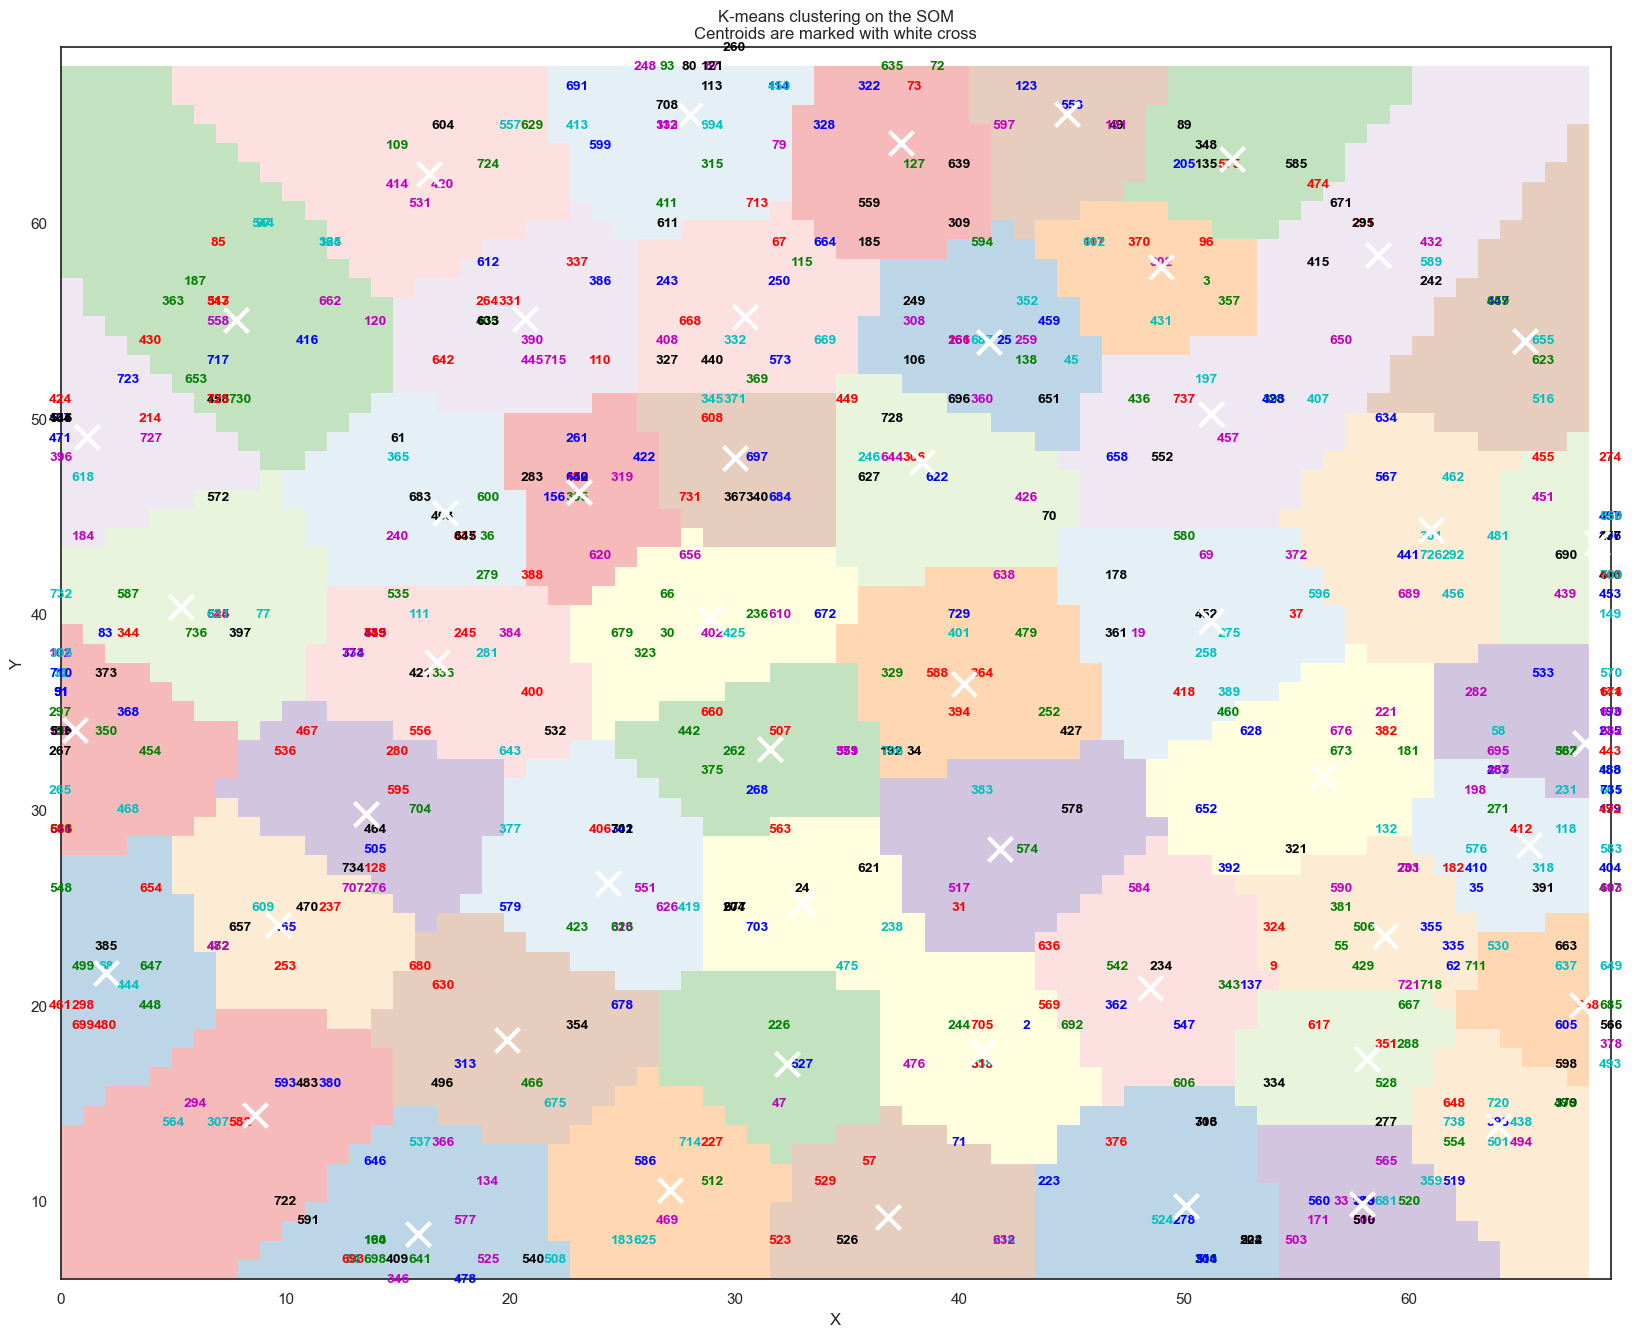

In [25]:
cycol = cycle('bgrcmk')

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 1.0  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X1[:, 0].min() , X1[:, 0].max() 
y_min, y_max = X1[:, 1].min() , X1[:, 1].max() 
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = km.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(20,16))
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",alpha=0.3
)

#plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)

for cnt in range(N):
    the_num=int(all_numbers[cnt])
    plt.text(X1[cnt, 0],X1[cnt, 1],the_num, color=next(cycol),ha="center", va="center",fontsize=10,fontweight="bold")




# Plot the centroids as a white X
centroids = km.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=300,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the SOM\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
plt.xlabel("X")
plt.ylabel("Y")
#plt.xticks(())
#plt.yticks(())
plt.show()

### Plot Groups of Spectra

In [26]:
# n_clu
ncols = 2
nrows = n_clu//ncols 
if n_clu/ncols> nrows:
    nrows+=1


/var/folders/m7/6pm3rhtj0c71ls7jj9mn1g740000gp/T/ipykernel_5402/1710306211.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


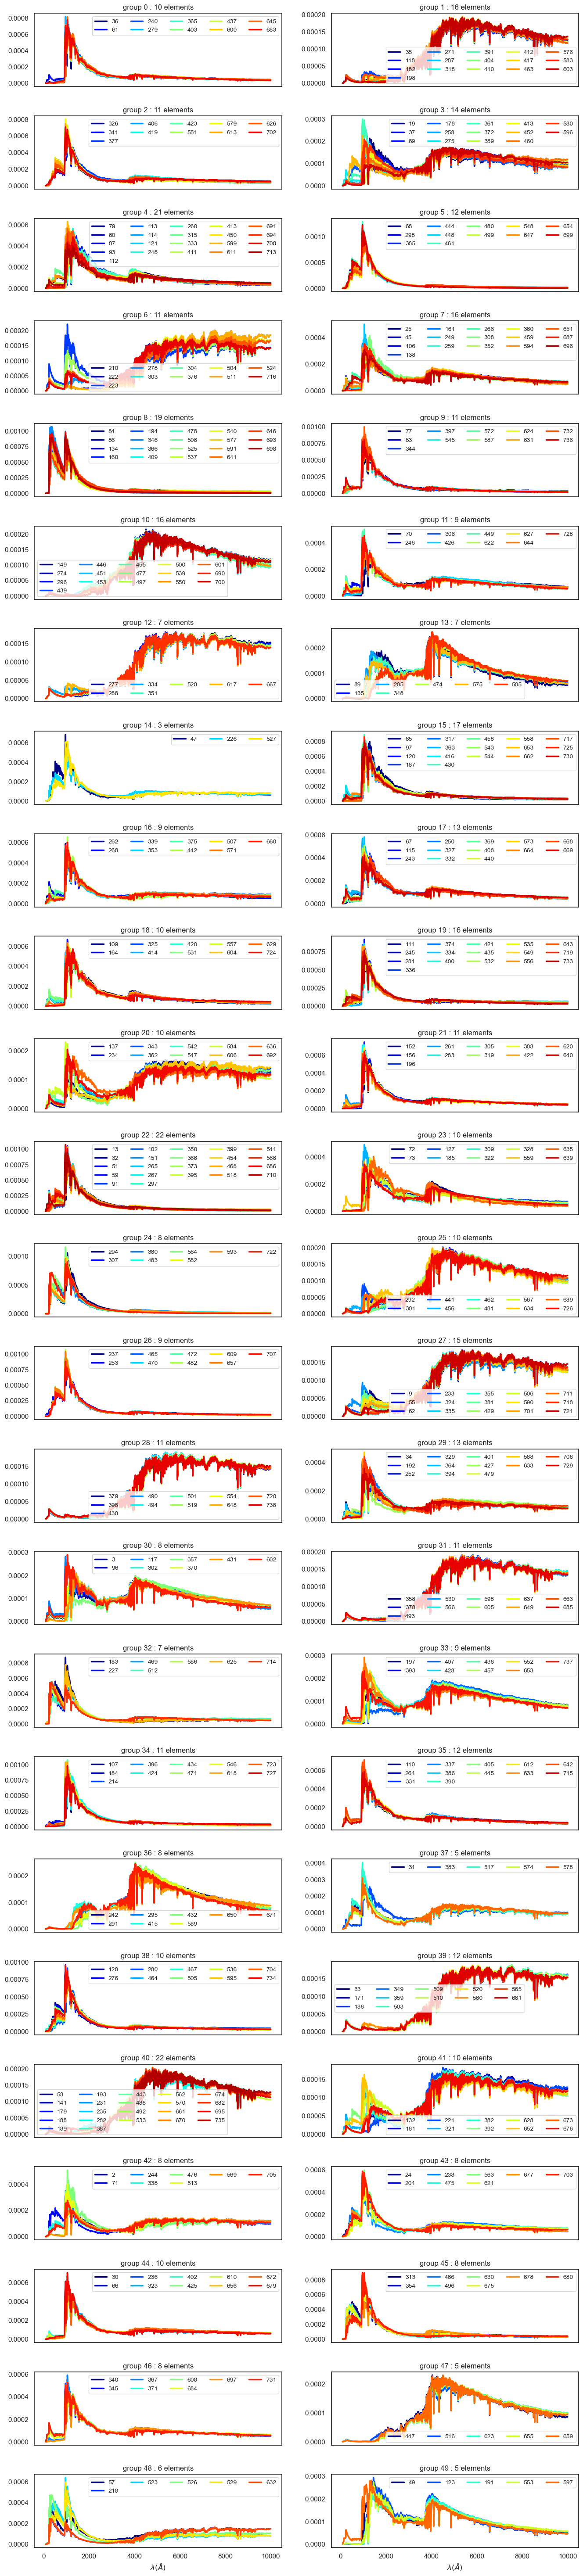

In [27]:

if ncols==2:
    fig = plt.figure(figsize=(16,nrows*3))
    gs = fig.add_gridspec(nrows, ncols, hspace=0.4, wspace=0.2)
elif ncols==4:
    fig = plt.figure(figsize=(20,nrows*3))
    gs = fig.add_gridspec(nrows, ncols, hspace=0.4, wspace=0.2)
elif ncols==1:
    fig = plt.figure(figsize=(10,nrows*3))
    gs = fig.add_gridspec(nrows, ncols, hspace=0.4, wspace=0.2)
else:
    fig = plt.figure(figsize=(20,nrows*3))
    gs = fig.add_gridspec(nrows, ncols, hspace=0.4, wspace=0.2)
    
    
#axs  = gs.subplots(sharex='col', sharey='row')
axs  = gs.subplots(sharex='col')

for icluster in range(km.n_clusters):
    
    irow=icluster//ncols
    icol=icluster-irow*ncols
    
    
    the_group = mydict[icluster]

    NTOPLOT=len(the_group)
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NTOPLOT)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NTOPLOT), alpha=1)
    
    icount=0
    for idx in the_group:
        the_num=all_numbers[idx]
        the_label=f"{the_num:.0f}"
        axs[irow,icol].plot(wavelengths,spec[idx,:],color=all_colors[icount],label=the_label)
        icount+=1
        
    axs[irow,icol].set_title(f"group {icluster} : {NTOPLOT} elements")
    if irow==nrows-1:
        axs[irow,icol].set_xlabel("$\lambda (\AA)$ ")
    axs[irow,icol].legend(loc="best",ncol=5,fontsize=10)
    
plt.tight_layout()

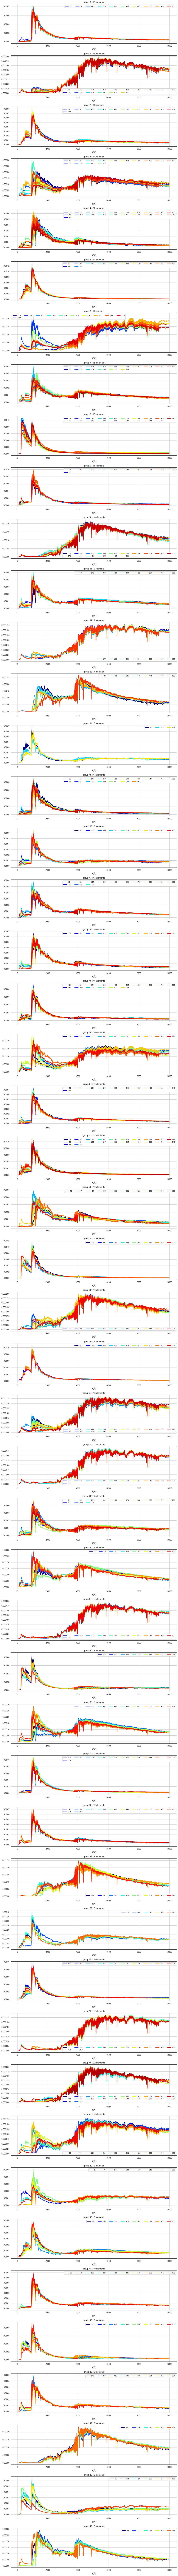

In [31]:
fig = plt.figure(figsize=(14, km.n_clusters*4))

for icluster in range(km.n_clusters):
    ax=fig.add_subplot(km.n_clusters,1,1+icluster)
    
    the_group = mydict[icluster]

    NTOPLOT=len(the_group)
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NTOPLOT)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NTOPLOT), alpha=1)
    
    icount=0
    for idx in the_group:
        the_num=all_numbers[idx]
        the_label=f"{the_num:.0f}"
        ax.plot(wavelengths,spec[idx,:],color=all_colors[icount],label=the_label)
        icount+=1
    ax.set_title(f"group {icluster} : {NTOPLOT} elements")
    ax.set_xlabel("$\lambda (\AA)$ ")
    ax.legend(loc="best",ncol=10,fontsize=10)
    ax.grid()
        
        
plt.tight_layout()

## Convergence

In [32]:
if not FLAG_CHECK_CONVERGENCE:
    assert False

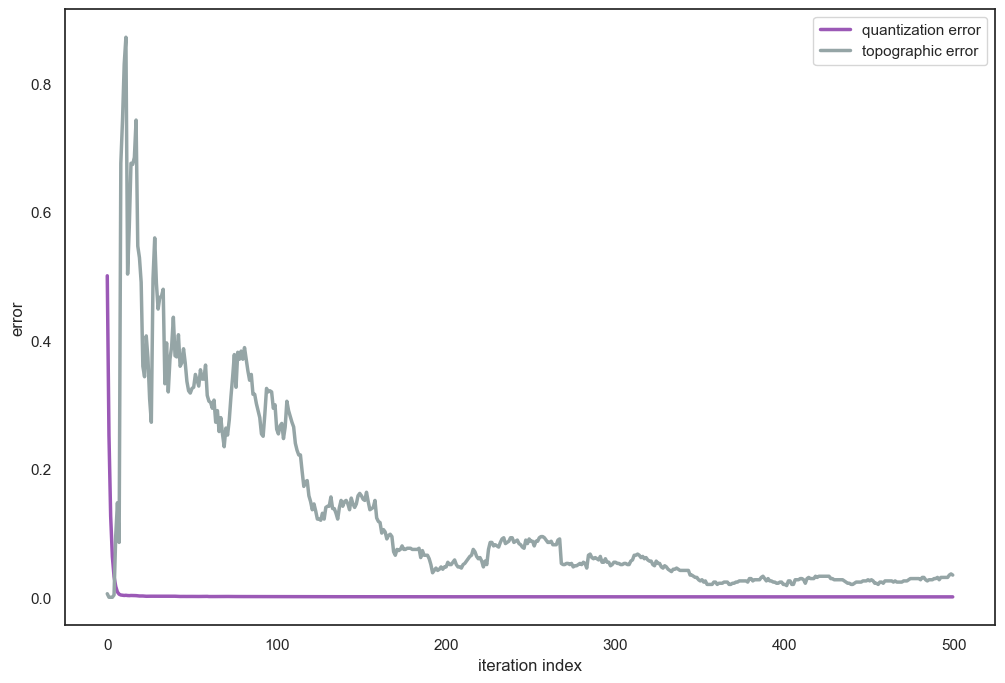

In [30]:
if FLAG_CHECK_CONVERGENCE:
    som = MiniSom(n_neurons, m_neurons, X.shape[1], sigma=7, learning_rate=.5,neighborhood_function='gaussian', random_seed=10)

    max_iter = Niter
    q_error = []
    t_error = []

    for i in range(max_iter):
        rand_i = np.random.randint(len(X))
        som.update(X[rand_i], som.winner(X[rand_i]), i, max_iter)
        q_error.append(som.quantization_error(X))
        t_error.append(som.topographic_error(X))

    plt.figure(figsize=(12,8))
    plt.plot(np.arange(max_iter), q_error, label='quantization error')
    plt.plot(np.arange(max_iter), t_error, label='topographic error')
    plt.ylabel('error')
    plt.xlabel('iteration index')
    plt.legend()
    plt.show()